# CS-439 Mini Project
Authors: *Christian Cristicello, Marcus Gruneau, Alejandro Noguerón*

In [1]:
from collections import defaultdict
import numpy as np
import numpy.matlib
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_svmlight_file
import random
import helpers
from helpers import *
from wngrad import WNGrad, WNGrad_C
import torch 
import torchvision
%matplotlib inline

### Index 
1. [Convex Settings](#1.-Convex-Settings)
    1. [Least Squares](#1.A-Least-Squares)
    2. [SVM](#1.B-SVM)
2. [Non-convex Settings](#2.-Non-convex-Settings)
    1. [Convolutional Neural Network](#2.A-Convolutional-Neural-Network)

# 1. Convex Settings
[Back to Index](#Index)

## 1.A Least Squares
[Back to Index](#Index)

First we define some auxiliary functions and load the data.

In [2]:
# Load utils for Least Squares objective/gradient computation
def calculate_objective(Axmb):
    """Calculate the mean squared error for vector Axmb = Ax - b."""
    return 1/2*np.mean(Axmb**2)

def calculate_L(b, A):
    """Calculate the smoothness constant for f"""
    eig = np.linalg.eigvals(A.T.dot(A))
    L = max(eig)/(A.shape[0])           # same as doing np.linalg.norm(A.T.dot(A), 2) / (A.shape[0])     
    return L

def compute_gradient(b, A, x):
    """Compute the gradient."""
    Axmb = A.dot(x) - b
    grad = A.T.dot(Axmb) / len(Axmb)
    return grad, Axmb

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
b, A = build_model_data(x, weight)

In [3]:
# Define Least Squares minimizer for WNGrad
class LeastSquaresWNGrad():

    def __init__(self, n_iter=10, b=1, lambda_=None, C=1):
        self.n_iter = n_iter
        self.b = b
        self.lambda_ = lambda_
        self.C = C
        
    def fit(self, X, Y):

        n_instances, n_features = X.shape
        
        Xt = torch.tensor(X, dtype=torch.float)
        Yt = torch.tensor(Y, dtype=torch.float)

        self.w = torch.zeros(n_features, requires_grad=True, dtype=torch.float)

        self.history = []
        self.gradhist = []
        self.brets = []
        
        optimizer = WNGrad_C([self.w], b=self.b, lambda_=self.lambda_, C=self.C)
        mse_loss = torch.nn.MSELoss(reduction='mean')

        for i in range(self.n_iter):  
            def closure():
                optimizer.zero_grad()
                output = Xt.mv(self.w)
                loss = mse_loss(output, Yt)
                loss.backward()
                return loss, i

            loss, grad_size, b_ret = optimizer.step(closure)
            self.history.append(loss)
            self.gradhist.append(grad_size)
            self.brets.append(b_ret)
                                      
        print('WNGrad final loss: {:.4f}'.format(loss))
        print('WNGrad final grad: {}'.format(self.gradhist[-1]))
        print('WNGrad final b: {}'.format(self.brets[-1]))

In [4]:
# Fit with different values of C
L = calculate_L(b, A)
print("L =", L)
# Convex smooth functions gamma_opt = 1/L
iter = 10000
regr1 = LeastSquaresWNGrad(n_iter=iter, b=None, lambda_=None, C=100)
regr1.fit(A, b)
regr2 = LeastSquaresWNGrad(n_iter=iter, b=None, lambda_=None, C=10)
regr2.fit(A, b)
regr3 = LeastSquaresWNGrad(n_iter=iter, b=None, lambda_=None, C=1)
regr3.fit(A, b)
regr4 = LeastSquaresWNGrad(n_iter=iter, b=None, lambda_=None, C=0.1)
regr4.fit(A, b)
regr5 = LeastSquaresWNGrad(n_iter=iter, b=None, lambda_=None, C=0.01)
regr5.fit(A, b)

L = 1.0000000000000013
0 None 149.04628
WNGrad final loss: 1982.3975
WNGrad final grad: 7805.8031174261705
WNGrad final b: 22108.546193599745
0 None 149.04628
WNGrad final loss: 540.1873
WNGrad final grad: 2037.3140816496598
WNGrad final b: 11576.12402058901
0 None 149.04628
WNGrad final loss: 404.3906
WNGrad final grad: 1494.190351088313
WNGrad final b: 10502.38734239358
0 None 149.04628
WNGrad final loss: 375.7448
WNGrad final grad: 1379.6221178120468
WNGrad final b: 10286.112329709447
0 None 149.04628
WNGrad final loss: 31.0961
WNGrad final grad: 1.296525044356386
WNGrad final b: 2816.734085317969


Calculate SGD with different values of $\lambda$

In [5]:
# First, declare gradient_descent function
def gradient_descent(b, A, initial_x, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store x and objective func. values
    xs = [initial_x]
    objectives = []
    x = initial_x
    for n_iter in range(max_iters):
        # compute objective, gradient
        grad, Axmb = compute_gradient(b, A, x)
       # print(grad)
        obj = calculate_objective(Axmb)
        # update x by a gradient descent step
        x = x - gamma * grad
        # store x and objective function value
        #print(np.sum(grad**2))
        xs.append(x)
        objectives.append(obj)
        #print("Gradient Descent({bi}/{ti}): objective={l}".format(
              #bi=n_iter, ti=max_iters - 1, l=obj))

    return objectives, xs

max_iters = 10000

# Declare gamma
gamma = 1e-2
# Initialization
x_initial = np.array([0,0])
# Start gradient descent.
gradient_objectives_naive_2, gradient_xs_naive = gradient_descent(b, A, x_initial, max_iters, gamma)

# Repeat for gamma = 1e-3
gamma = 1e-4
x_initial = np.array([0,0])
gradient_objectives_naive_3, gradient_xs_naive = gradient_descent(b, A, x_initial, max_iters, gamma)

# Repeat for gamma = 1e-4
gamma = 1e-4
x_initial = np.array([0,0])
gradient_objectives_naive_4, gradient_xs_naive = gradient_descent(b, A, x_initial, max_iters, gamma)

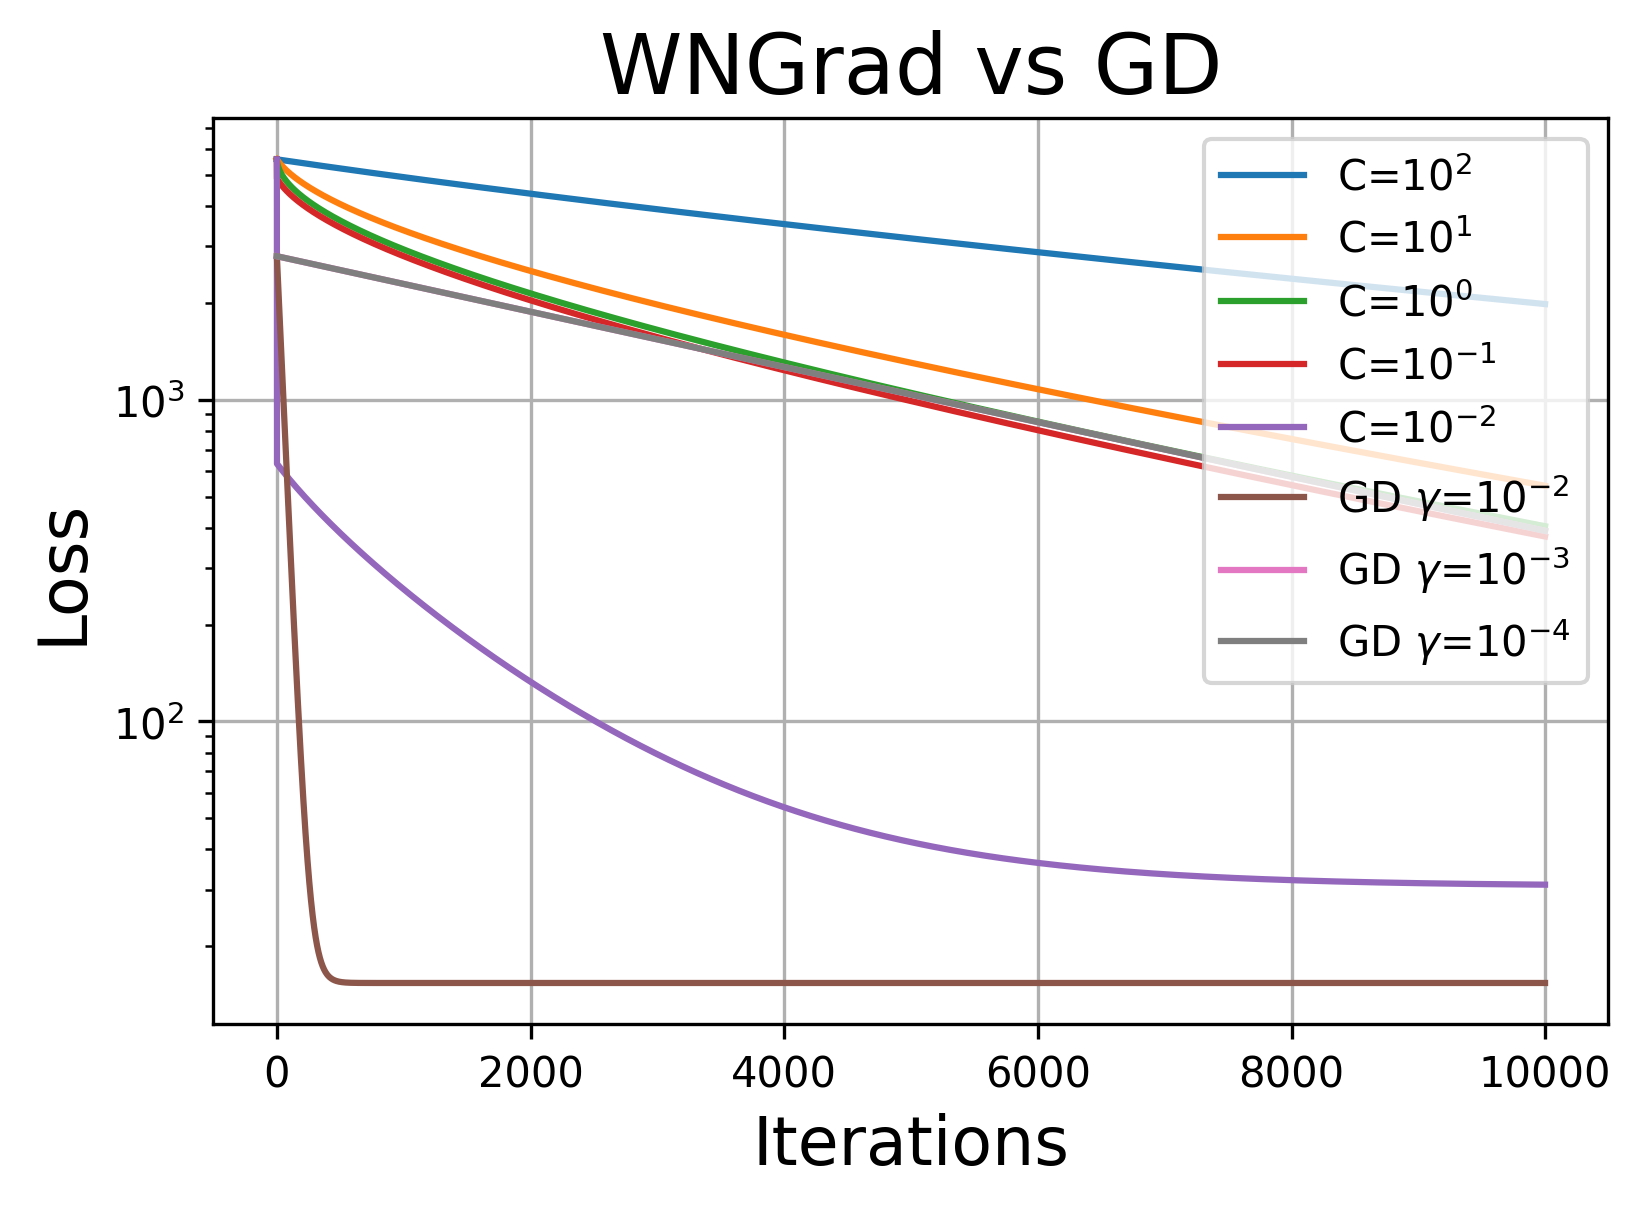

In [6]:
plt.plot(regr1.history, label="C=$10^{2}$");
plt.plot(regr2.history, label="C=$10^{1}$");
plt.plot(regr3.history, label="C=$10^{0}$");
plt.plot(regr4.history, label="C=$10^{-1}$");
plt.plot(regr5.history, label="C=$10^{-2}$");
plt.plot(gradient_objectives_naive_2, label="GD $\gamma$=$10^{-2}$")
plt.plot(gradient_objectives_naive_3, label="GD $\gamma$=$10^{-3}$")
plt.plot(gradient_objectives_naive_4, label="GD $\gamma$=$10^{-4}$")
plt.yscale("log"); plt.grid()
plt.title('WNGrad vs GD', fontsize = 20)
plt.xlabel("Iterations", fontsize=16)
fig = plt.gcf()
plt.ylabel("Loss", fontsize=16); fig.set_dpi(300)
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()

## 1.B SVM
[Back to Index](#Index)

In [7]:
# Import data
DATA_TRAIN_PATH = '../data/w1a.txt' # https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html

A, y = load_svmlight_file(DATA_TRAIN_PATH)
A = A.toarray()
print(y.shape, A.shape)

(2477,) (2477, 300)


In [8]:
def stochastic_gradient_descent_svm_demo(A, b, gamma, batch_size=1, trace=False):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(A)
    max_iter = 100000
    lambda_ = 0.01
    
    
    w_t = np.zeros(num_features)
    
    for current_iter in range(max_iter):
        i = random.randint(0,num_data_points - 1)
        b_batch, A_batch = b[i], A[i]
        gradient = helpers.compute_gradient_svm(np.array([A_batch]), np.array([b_batch]), lambda_, w_t, num_data_points)
        # Update rule for SGD SVM
        w_t = w_t - gamma * gradient
        
        if current_iter % 10000 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            print(f'iteration={current_iter}, primal:{primal_value:.5f}, gradient_shape = {gradient.shape}, gradient_mean/std = {gradient.mean():.2f}, {gradient.std():.2f}, wt_mean = {w_t.mean():.2f}, {w_t.std():.2f}')
        if current_iter % 100 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            if trace:
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
    print("training accuracy = {l}".format(l=helpers.calculate_accuracy(y, A, w_t)))
    return history, w_t


def wn_grad_svm_demo(A, y, C=1, trace=False, batch_size = None, b_sq = False, max_iter = 100000):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(A)
    lambda_ = 0.01
    if batch_size == None:
        A_batch, y_batch = np.copy(A), np.copy(y)
    
    
    # Initiliaze weights w_t
    w_t = np.zeros(num_features)
    
    
    # Iterate
    for current_iter in range(max_iter):
        if batch_size != None:
            i = random.randint(0,num_data_points - batch_size)
            A_batch, y_batch = np.copy(A[i:i+batch_size, :]), np.copy(y[i:i+batch_size]) 
        else:
            A_batch, y_batch = np.copy(A), np.copy(y)
        
        ####### Compute gradient
        gradient = helpers.compute_gradient_svm(A_batch, y_batch, lambda_, w_t, num_data_points)
        
        # If necessary, initialize b param
        if current_iter == 0:
            # If necessary, b parameter initialization
            if C == None:
                initial_b = 0
                for i in np.arange(-0.5, 0.5, 0.2):                    
                    w_t_close = np.random.normal(w_t.mean(), np.array([10], dtype = float)**i, size = w_t.shape)
                    gradient_temp = helpers.compute_gradient_svm(A, y, lambda_, w_t, num_data_points)
                    gradient_close = helpers.compute_gradient_svm(A, y, lambda_, w_t_close, num_data_points)
                    b = np.linalg.norm(gradient_temp - gradient_close)/np.linalg.norm(w_t - w_t_close)
                    if b > initial_b:
                        initial_b = b
                b = initial_b
                print('initial b:', initial_b, np.linalg.norm(gradient))
            else:
                # If C was specified, initialization will be in terms of the gradient norm
                b = C*np.linalg.norm(gradient)
        
        # Update params
        w_t = w_t - gradient/b
        
        # Compute gradient again with updated params
#         gradient = helpers.compute_gradient_svm(A_batch, y_batch, lambda_, w_t, num_data_points)
        # Update b
        if b_sq:
            b = b + (np.linalg.norm(gradient)**2)/b
        else:
            b = b + (np.linalg.norm(gradient))/b
        
#         w_t = w_t - gradient*0.0001
        
        if current_iter % 10000 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            print(f'iteration={current_iter}, primal:{primal_value:.5f}, b = {b}, gradient_shape = {gradient.shape}, gradient_mean/std = {gradient.mean():.2f}, {gradient.std():.2f}, \
wt_shape = {w_t.shape}, wt_mean = {w_t.mean():.2f}, {w_t.std():.2f}')
        if current_iter % 100 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            if trace:
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
                history['gradient_norm'].append(np.linalg.norm(gradient))
                history['b'].append(b)
    print("training accuracy = {l}".format(l=helpers.calculate_accuracy(y, A, w_t)))
    return history, w_t


def coordinate_descent_for_svm_demo_wngrad(y, A, trace=False):
    stepsize = 0.001 # best is between 0.001 and 0.0001
    max_iter = 100000
    lambda_ = 0.01
    history = defaultdict(list) if trace else None
    
    num_examples, num_features = A.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)
    
    next_stepsize = stepsize
    
    for it in range(max_iter):
        # i = sample one data point uniformly at random from the columns of A
        i = random.randint(0,num_examples-1)
        
        w, alpha, next_stepsize = helpers.calculate_coordinate_update_wngrad(y, A, lambda_, alpha, w, i, next_stepsize)
            
        if it % 10000 == 0:
            # primal objective
            primal_value = helpers.calculate_primal_objective(y, A, w, lambda_)
            # dual objective
            dual_value = helpers.calculate_dual_objective(y, A, w, alpha, lambda_)
            # primal dual gap
            duality_gap = primal_value - dual_value
            
            print('iteration=%i, primal:%.5f, dual:%.5f, gap:%.5f'%(
                    it, primal_value, dual_value, duality_gap))
        if it % 1000 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w, lambda_)
            if trace:
                history["objective_function"] += [primal_value]
                history['iter'].append(it)

            
    print("training accuracy = {l}".format(l=helpers.calculate_accuracy(y, A, w)))
    return history

In [9]:
history_wngrad, w_t_wngrad = wn_grad_svm_demo(A, y, C=None, trace=True, batch_size = 100, max_iter = 100000)
history_wngrad_b2, w_t_wngrad = wn_grad_svm_demo(A, y, C=None, trace=True, batch_size = 100, b_sq = True, max_iter = 100000)
history_sgd_4, wt_sgd = stochastic_gradient_descent_svm_demo(A, y, 1e-4, batch_size=500, trace=True)
history_sgd_3, wt_sgd = stochastic_gradient_descent_svm_demo(A, y, 1e-3, batch_size=500, trace=True)
history_cd = coordinate_descent_for_svm_demo_wngrad(y, A, trace=True)

initial b: 185.32867229871917 2417.5824547262087
iteration=0, primal:801.43367, b = 198.37351001724264, gradient_shape = (300,), gradient_mean/std = 78.11, 115.68, wt_shape = (300,), wt_mean = -0.42, 0.62
iteration=10000, primal:241.31288, b = 950.2830381711477, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.05, 1.54
iteration=20000, primal:237.02157, b = 1241.5750851168343, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.03, 1.71
iteration=30000, primal:236.61368, b = 1450.9817387928376, gradient_shape = (300,), gradient_mean/std = 0.33, 3.49, wt_shape = (300,), wt_mean = -0.03, 1.78
iteration=40000, primal:235.84078, b = 1616.385008728821, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.02, 1.80
iteration=50000, primal:235.15575, b = 1759.4107931378069, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.02, 1.80
iteratio

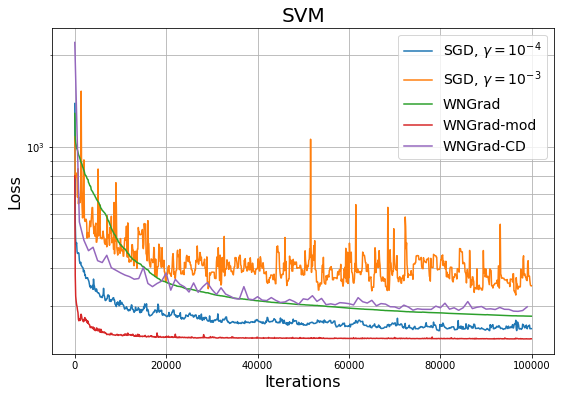

In [10]:
plt.figure(figsize = (9, 6))
fig = plt.gcf()
ax = plt.gca()
plt.semilogy(history_sgd_4["iter"], history_sgd_4["objective_function"], label="SGD, $\gamma = 10^{-4}$")
plt.semilogy(history_sgd_3["iter"], history_sgd_3["objective_function"], label="SGD, $\gamma = 10^{-3}$")
plt.semilogy(history_wngrad_b2["iter"], history_wngrad_b2["objective_function"], label="WNGrad")
plt.semilogy(history_wngrad["iter"], history_wngrad["objective_function"], label="WNGrad-mod")
plt.semilogy(history_cd["iter"], history_cd["objective_function"], label="WNGrad-CD")
plt.grid(which = 'minor')
plt.grid(which = 'major')
plt.ylabel('Loss', fontsize = 16)
plt.xlabel('Iterations', fontsize = 16)
# plt.gcf().set_dpi(300)
plt.legend(prop={'size': 14})
plt.title('SVM', fontsize = 20)
plt.show()
fig.savefig('SVM')

# 2. Non-convex Settings 
[Back to Index](#Index)

## 2.A Convolutional Neural Network
[Back to Index](#Index)

In [11]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
trainloader_1batch = torch.utils.data.DataLoader(trainset, batch_size=50000,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
def train(optimizer, net, epochs):
    history = defaultdict(list)
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            net.train()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            if 'SGD' in str(optimizer):
                optimizer.step()
            elif 'WNGrad' in str(optimizer):
                
                # Store original parameters, and flatten params and grad
                if epoch == 0 and i == 0:
                    b_candidates = []
                    orig_param_list = []
                    grad_flat = torch.empty((0,))
                    param_flat = torch.empty((0,))
                    layers = []
                    for name, param in net.named_parameters():
                        orig_param_list.append(param)
                        grad_flat = torch.cat((grad_flat, param.grad.flatten()))
                        param_flat = torch.cat((param_flat, param.flatten()))
                        layers.append(name.split('.')[0])

                    for i in np.arange(-5, 0, 0.1):
                        for i_layer, layer in enumerate(layers):
                            if i_layer % 2 == 0: # Weight
                                getattr(net, layers[i_layer].split('.')[0]).weight = torch.nn.Parameter(
                                    orig_param_list[i_layer] + torch.empty_like(orig_param_list[i_layer]).normal_(0, 10**i))
                            else:
                                getattr(net, layers[i_layer].split('.')[0]).bias = torch.nn.Parameter(
                                    orig_param_list[i_layer] + torch.empty_like(orig_param_list[i_layer]).normal_(0, 10**i))



                        # Get gradient
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)
#                         print(getattr(net, layers[i_layer].split('.')[0]).bias.grad)
                        loss.backward()

                        # Retreive gradient
                        grad_flat_temp = torch.empty((0,))
                        param_flat_temp = torch.empty((0,))
                        for name, param in net.named_parameters():
                            grad_flat_temp = torch.cat((grad_flat_temp, param.grad.flatten()))
                            param_flat_temp = torch.cat((param_flat_temp, param.flatten()))
                        
#                         print(grad_flat_temp.mean(), grad_flat.mean(), param_flat_temp.mean(), param_flat.mean(),)
                        b_candidates.append((grad_flat_temp - grad_flat).norm(2)/(param_flat_temp - param_flat).norm(2))

                        # Once initialization search is over...
                    
                    # Put originals back in place
                    for i_layer, layer in enumerate(layers):
                        if i_layer % 2 == 0: # Weight
                            getattr(net, layers[i_layer].split('.')[0]).weight = orig_param_list[i_layer]
                        else:
                            getattr(net, layers[i_layer].split('.')[0]).bias = orig_param_list[i_layer]
                    
                    # And choose a b
#                     print(b_candidates)
                    b = max(b_candidates)
#                     b = 50
                    print('Initial_b: ', b, 'Max candidates: ', sorted(b_candidates)[-2])
                    optimizer.b = b
#                     raise Exception()
                elif i % 500 == 499:
                    print('Current b:', optimizer.b)
                def closure():
                    optimizer.zero_grad()
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    return loss
                optimizer.step(closure)

            # print statistics
            running_loss += loss.item()
#             if i % 10 == 9:    # Store every 10 mini-batches
#                 history["iter"].append(i*(epoch+1))
#                 history["loss"].append(running_loss)
# #                 print(f'loss = {running_loss}')
# #                 print('[%d, %5d] loss: %.3f' %
# #                       (epoch + 1, i + 1, running_loss / 2000))
#                 running_loss = 0.0
            if i % 500 == 499:    # print every 2000 mini-batches
                net.eval()
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 5000))
                history["iter"].append(i+len(trainloader)*epoch+1)
                history["train loss"].append(running_loss)
                running_loss = 0.0
                total = 0
                correct = 0
                with torch.no_grad():
                    test_loss = 0
                    for data in testloader:
                        images, labels = data
                        # calculate outputs by running images through the network
                        outputs = net(images)
                        test_loss += criterion(outputs, labels)
                        
                        # the class with the highest energy is what we choose as prediction
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                history["test accuracy"].append(100*correct/total)
                print(100*correct/total, '%')
                history["test loss"].append(test_loss)
#                 print('Accuracy of the network on the 10000 test images: %d %%' % (
#                     100 * correct / total))
    return history

In [14]:
# Define Criterion
epochs = 2
criterion = torch.nn.CrossEntropyLoss()
net_SGD = Net()
optimizer_SGD = torch.optim.SGD(net_SGD.parameters(), lr=0.001, momentum=0.9)
history = train(optimizer_SGD, net_SGD, epochs)
# Redo with WNGrad-mod
net_WNGrad = Net()
optimizer_WNGrad_mod = WNGrad(net_WNGrad.parameters())
history_WNGrad_mod = train(optimizer_WNGrad_mod, net_WNGrad, epochs)
# Redo with WNGrad
net_WNGrad = Net()
optimizer_WNGrad_bsq = WNGrad(net_WNGrad.parameters(), b_sq = True)
history_WNGrad_bsq = train(optimizer_WNGrad_bsq, net_WNGrad, epochs)

[1,   500] loss: 0.230
13.84 %
[1,  1000] loss: 0.229
18.57 %
[1,  1500] loss: 0.221
22.09 %
[1,  2000] loss: 0.205
26.61 %
[1,  2500] loss: 0.195
30.88 %
[1,  3000] loss: 0.184
31.46 %
[1,  3500] loss: 0.178
33.5 %
[1,  4000] loss: 0.169
40.52 %
[1,  4500] loss: 0.163
40.45 %
[1,  5000] loss: 0.160
40.43 %
[2,   500] loss: 0.158
42.34 %
[2,  1000] loss: 0.155
45.55 %
[2,  1500] loss: 0.149
44.43 %
[2,  2000] loss: 0.148
46.32 %
[2,  2500] loss: 0.151
45.59 %
[2,  3000] loss: 0.146
48.06 %
[2,  3500] loss: 0.144
47.26 %
[2,  4000] loss: 0.142
44.52 %
[2,  4500] loss: 0.138
49.82 %
[2,  5000] loss: 0.139
48.11 %
Initial_b:  tensor(49.9389, grad_fn=<DivBackward0>) Max candidates:  tensor(47.5333, grad_fn=<DivBackward0>)
Current b: tensor(53.6049)
[1,   500] loss: 1.674
18.59 %
Current b: tensor(65.2286)
[1,  1000] loss: 0.218
26.26 %
Current b: tensor(83.8701)
[1,  1500] loss: 0.195
31.78 %
Current b: tensor(100.9657)
[1,  2000] loss: 0.184
35.37 %
Current b: tensor(117.2829)
[1,  2500] 

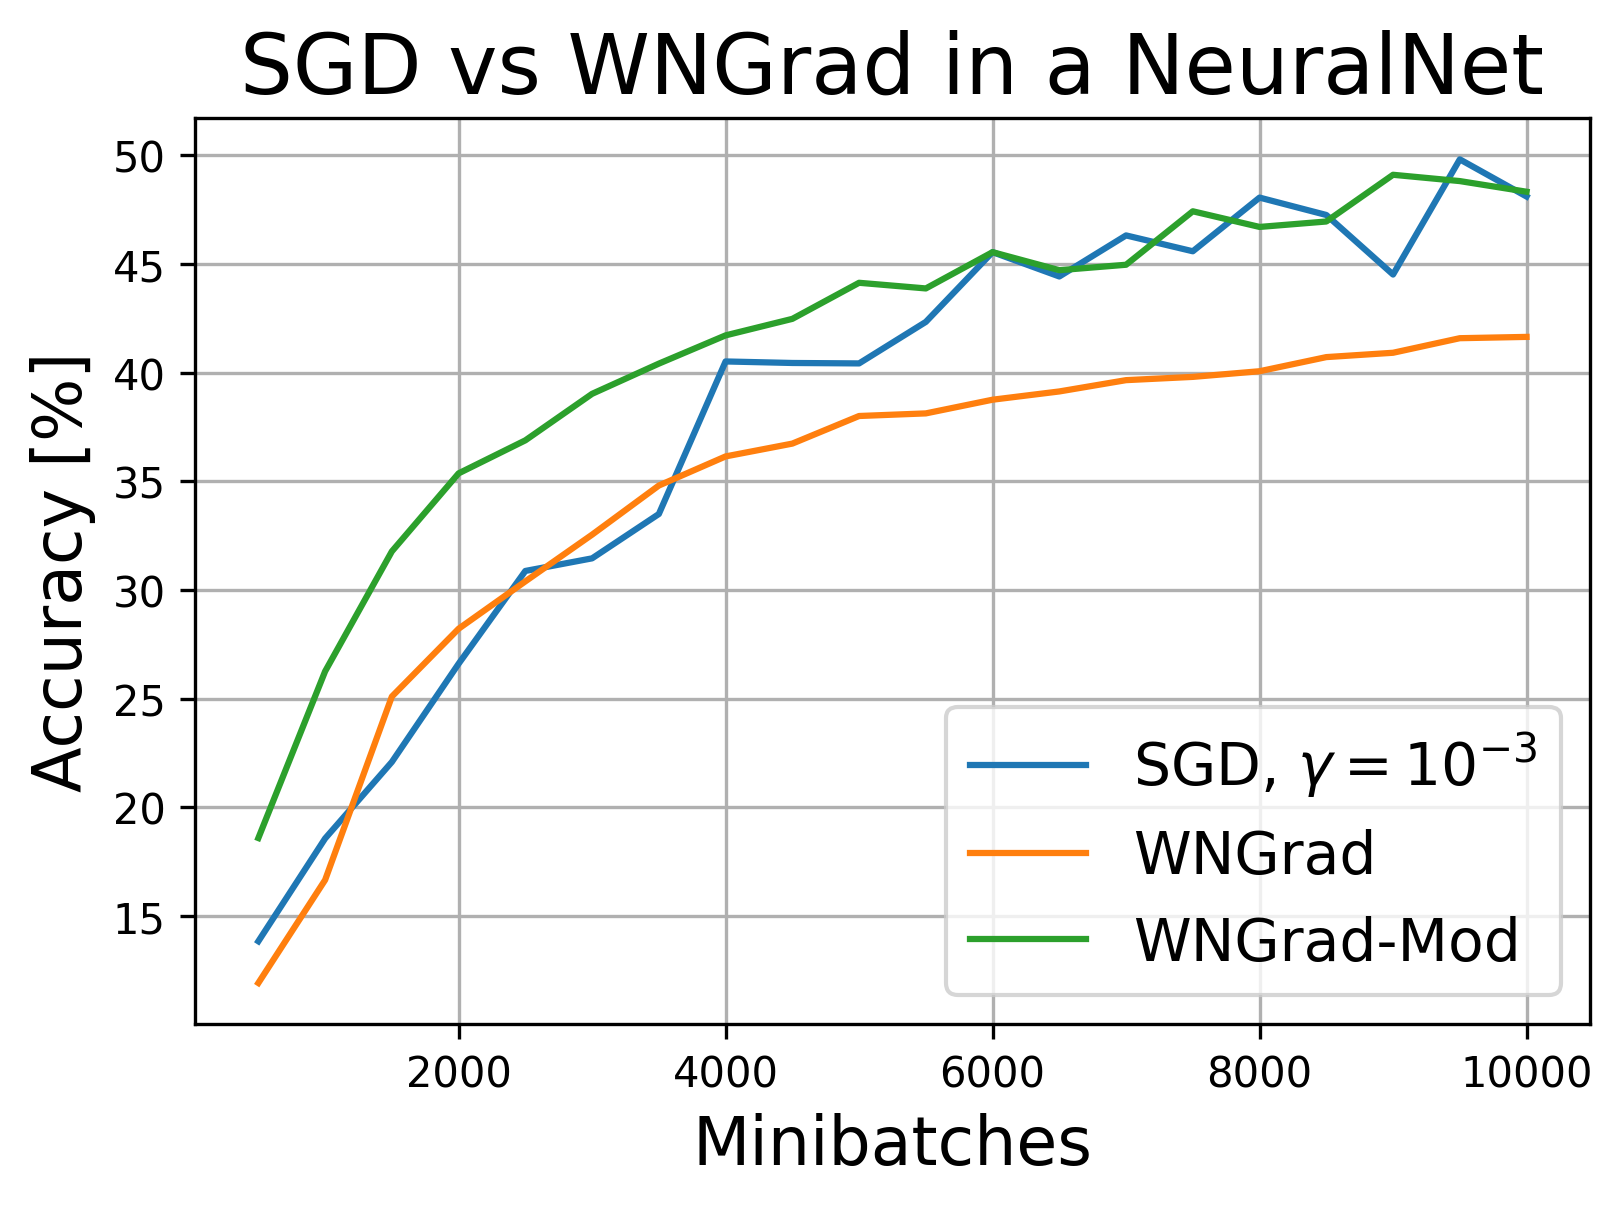

In [15]:
plt.figure()
# SGD
plt.plot(history["iter"], history["test accuracy"], label="SGD, $\gamma = 10^{-3}$")
# WNGRAD
plt.plot(history_WNGrad_bsq["iter"], history_WNGrad_bsq["test accuracy"], label="WNGrad")
# WN Grad mod
plt.plot(history_WNGrad_mod["iter"], history_WNGrad_mod["test accuracy"], label="WNGrad-Mod")
ax = plt.gca(); ax.grid(); fig = plt.gcf()
plt.xlabel('Minibatches', fontsize=16); plt.ylabel('Accuracy [%]', fontsize = 16)
plt.gcf().set_dpi(300)
plt.legend(prop={'size': 14}); plt.title('SGD vs WNGrad in a NeuralNet', fontsize = 20)
plt.show()